# 1. Introduction

Nikki Satmaka - Batch 11

## Description

Dataset is taken from [Kaggle](https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset)

Context:

This dataset contains 

### Objective

- pass

### Problem Statement

- pass

## Prepare Dataset

In [1]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# prepare kaggle environment
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/03-resources/kaggle/kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
# download dataset
!mkdir data
!kaggle datasets download --p data --unzip clmentbisaillon/fake-and-real-news-dataset

 81% 33.0M/41.0M [00:00<00:00, 45.1MB/s]
100% 41.0M/41.0M [00:00<00:00, 45.7MB/s]


In [4]:
# install dependencies
!pip install feature-engine --quiet --progress-bar off
!python -m spacy download en_core_web_sm --quiet --progress-bar off
!python -m nltk.downloader stopwords punkt --quiet 

# copy packages directory
!cp -r /content/drive/MyDrive/03-resources/python_pkgs/packages ./




✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))


# 2. Importing Libraries

In [96]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pathlib import Path
import joblib
import re

from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings('ignore')

from wordcloud import WordCloud, STOPWORDS

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

import spacy

# Split Dataset and Standarize the Datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer


# Neural Network
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import TextVectorization, Embedding
from tensorflow.keras.layers import InputLayer, Dense
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM, GRU

# Evaluate Classification Models
from sklearn.metrics import classification_report

# Useful functions
from packages.checker import check_missing
from packages.checker import check_links_only
from packages.outlier_handling import outlier_summary
from packages.visualization import kdeplot, plot_loss, plot_acc
from packages.imputation_handling import drop_title_links_only

from packages.text_preprocessing import combine_text
from packages.text_preprocessing import clean_text, strip_stopwords 
from packages.text_preprocessing import stem_text, lemmatize_text


pd.set_option('display.precision', 2)

sns.set_theme(style='darkgrid', palette='Set1')

# set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

%matplotlib inline

# 3. Data Loading

In [6]:
# load dataset
df_fake_ori = pd.read_csv("data/Fake.csv")
df_real_ori = pd.read_csv("data/True.csv")

# make a copy of the original dataframe
df_fake = df_fake_ori.copy()
df_real = df_real_ori.copy()

# display the first 5 entries of fake news data
df_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [7]:
# display the first 5 entries of real news data
df_real.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


## Data Understanding

In [8]:
# check dataset shape
print(f"Fake news dataset shape: {df_fake.shape}")
print(f"Real news dataset shape: {df_real.shape}")

Fake news dataset shape: (23481, 4)
Real news dataset shape: (21417, 4)


There are 21417 instances and 4 columns of real news data\
There are 23481 instances and 4 columns of fake news data

In [9]:
# check fake news dataset info
df_fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [10]:
# check real news dataset info
df_real.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


Both dataset have their date as string object. I'm going to convert them to datetime object.\
However, I'm going to combine them first. Both dataframes have the same features, so we can safely proceed.

## Combine Dataset
Since the dataset was separated between real and fake news, let's combine them into one dataframe

In [11]:
# define target variable, 0 for fake news, 1 for real news
df_fake['target'] = 0
df_real['target'] = 1

# concat datasets and reset index
df_ori = pd.concat([df_fake, df_real]).reset_index(drop=True)

# create backup
df = df_ori.copy()

# display the first five rows of the dataset
df.head()

,title,text,subject,date,target
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [12]:
# check dataset shape
df.shape

(44898, 5)

There are 44,898 instances of data with 5 columns

## Check Missing values and Duplicates

In [13]:
# check missing values in dataset
check_missing(df)

,feats,tot_missing,tot_missing_pct


Great! There are no missing values

In [14]:
# check duplicate values in dataset
df[df.duplicated()]

,title,text,subject,date,target
9942,HILLARY TWEETS MESSAGE In Defense Of DACA…OOPS...,No time to waste we've got to fight with eve...,politics,"Sep 9, 2017",0
11446,FORMER DEMOCRAT WARNS Young Americans: “Rioter...,"Who is silencing political speech, physically...",politics,"Mar 10, 2017",0
14925,[VIDEO] #BlackLivesMatter Terrorists Storm Dar...,They were probably just looking for a safe sp...,politics,"Nov 16, 2015",0
23926,Senate tax bill stalls on deficit-focused 'tri...,WASHINGTON (Reuters) - The U.S. Senate on Thur...,politicsNews,"November 30, 2017",1
24259,Trump warns 'rogue regime' North Korea of grav...,BEIJING (Reuters) - U.S. President Donald Trum...,politicsNews,"November 8, 2017",1
...,...,...,...,...,...
44709,France unveils labor reforms in first step to ...,PARIS (Reuters) - French President Emmanuel Ma...,worldnews,"August 31, 2017",1
44744,Guatemala top court sides with U.N. graft unit...,GUATEMALA CITY (Reuters) - Guatemala s top cou...,worldnews,"August 29, 2017",1
44771,"Europeans, Africans agree renewed push to tack...",PARIS (Reuters) - Europe s big four continen...,worldnews,"August 28, 2017",1
44834,Thailand's ousted PM Yingluck has fled abroad:...,BANGKOK (Reuters) - Ousted Thai prime minister...,worldnews,"August 25, 2017",1


We found some duplicates in our dataset. Let's drop them

In [15]:
# drop duplicates
df = df[~df.duplicated()]

In [16]:
df.shape

(44689, 5)

We now have 44,689 instances of data left

## Check for Dataset Imbalance

Check whether the target variable of the dataset is balance

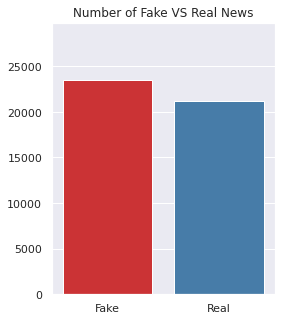

In [17]:
# check for imbalance in target variable
plt.figure(figsize=(4,5))
sns.countplot(data=df, x='target')
plt.title('Number of Fake VS Real News')
plt.xlabel(None)
plt.ylabel(None)
plt.ylim(0, df.shape[0] / 1.5)
plt.xticks([0, 1], ['Fake', 'Real'])

plt.show()

We can see that our data has similar number of fake and real news. Hence, the data is quite balanced and we won't need to oversample or undersample

## Splitting Dataset

We need to split the dataset into train and test sets before we do any EDA.\
We do our EDA on the train set so as to not have any bias towards the whole dataset.

### Split train and test set

In [18]:
# split sets to training+validation and testing sets
df_train_valid, df_test = train_test_split(
    df,
    test_size=0.20,
    random_state=42,
    stratify=df['target']
)

print('df_train_valid Size:', df_train_valid.shape)
print('df_test Size:', df_test.shape)

df_train_valid Size: (35751, 5)
df_test Size: (8938, 5)


### Split train and validation set

In [19]:
# split sets to training and validation sets
df_train, df_valid = train_test_split(
    df_train_valid,
    test_size=0.20,
    random_state=42,
    stratify=df_train_valid['target']
)

print('df_train Size:', df_train.shape)
print('df_valid Size:', df_valid.shape)

df_train Size: (28600, 5)
df_valid Size: (7151, 5)


In [20]:
# print datasets shape
print(f'df_train shape: {df_train.shape}')
print(f'df_valid shape: {df_valid.shape}')
print(f'df_test shape: {df_test.shape}')

df_train shape: (28600, 5)
df_valid shape: (7151, 5)
df_test shape: (8938, 5)


In [21]:
# backup the train set that we are gonna perform EDA on
df_train_ori = df_train.copy()

# 4. Exploratory Data Analysis

## Subjects

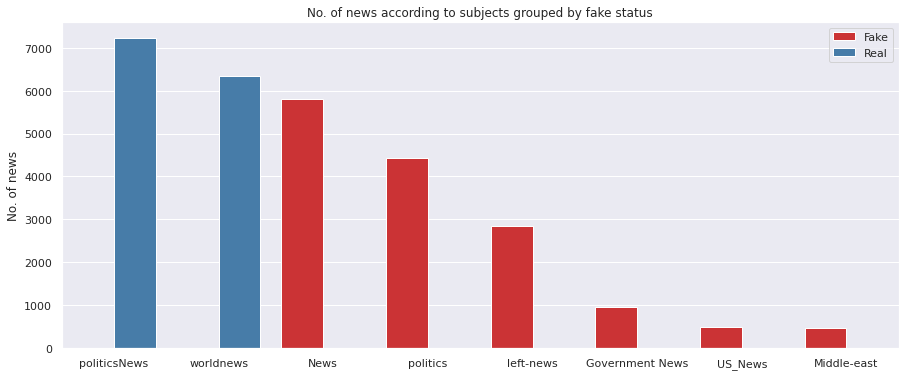

In [22]:
# plot number of news according to subjects
plt.figure(figsize=(15, 6))
sns.countplot(
    data=df_train,
    x='subject',
    hue='target',
    order=df_train['subject'].value_counts().index,
)
plt.title(f'No. of news according to subjects grouped by fake status')
plt.xlabel(None)
plt.ylabel('No. of news')

plt.legend(labels=['Fake', 'Real'])
plt.show()

We can see that real and fake news have totally different subjects. This might be a giveaway if we were to include this feature in our machine learning model later on

## Date

In [23]:
# attempt to convert date to datetime object to analyze time intervals
try:
    pd.to_datetime(df_train['date'])
except Exception as e:
    print(e)

Unknown string format: https://fedup.wpengine.com/wp-content/uploads/2015/04/entitled.jpg


That's weird. Why would there be a string in a date feature? Let alone a link.\
Let's check for any links in the date feature

In [24]:
# check for dates which contains link
df_train[df_train['date'].str.contains('http')]

,title,text,subject,date,target
21870,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,left-news,https://fedup.wpengine.com/wp-content/uploads/...,0
21869,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,left-news,https://fedup.wpengine.com/wp-content/uploads/...,0
17433,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,Government News,https://fedup.wpengine.com/wp-content/uploads/...,0
9358,https://100percentfedup.com/served-roy-moore-v...,https://100percentfedup.com/served-roy-moore-v...,politics,https://100percentfedup.com/served-roy-moore-v...,0
15840,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,politics,https://fedup.wpengine.com/wp-content/uploads/...,0
15508,https://100percentfedup.com/12-yr-old-black-co...,https://100percentfedup.com/12-yr-old-black-co...,politics,https://100percentfedup.com/12-yr-old-black-co...,0


There are 6 of them, and it's not just the date feature. The same links can also be found in the title and text features. This could be treated as missing values since they don't contain actually news

## Corpus

In [25]:
# display the first instance of the dataset
df_train.iloc[0]

title       This Fantastic Obama Speech Shows Us How A RE...
text       We just took a massive step closer to nuclear ...
subject                                                 News
date                                          August 9, 2017
target                                                     0
Name: 604, dtype: object

In [26]:
# display the title of the first instance 
df_train.iloc[0]['title']

' This Fantastic Obama Speech Shows Us How A REAL President Would Be Acting Right Now (VIDEO)'

In [27]:
# display the title of the first text 
df_train.iloc[0]['text']

'We just took a massive step closer to nuclear war with North Korea, and while Secretary of State Rex Tillerson keeps trying to reassure our allies that we re trying to bring North Korea to the negotiating table rather than just annihilate the entire planet, Trump is still posturing like a male peacock fanning his tail feathers. We don t need a peacock. We need a diplomat. Here s why:BREAKING: North Korea says it will complete plan to attack waters near Guam by mid-August then wait for commander in chief s order.  The Associated Press (@AP) August 9, 2017So the Georgia Democratic Party decided to remind us of exactly what a real president would be doing right now. President Obama, who believed in the diplomacy that Trump s immature machismo says is simply weakness (because why try diplomacy when you can fan your peacock feathers and strut?), always spoke eloquently on U.S. foreign policy and on war, and emphasized the necessity of working with the rest of the world to neutralize threat

It seems like `title` and `text` are two features which make the most important content of the news. Since NLP are performed on a body of text, I'm only going to use one feature, so I'm going to combine these features into one later on

## Wordcloud

In [ ]:
# create word cloud object
wc =  WordCloud(
    max_words=2000,
    stopwords=STOPWORDS
)

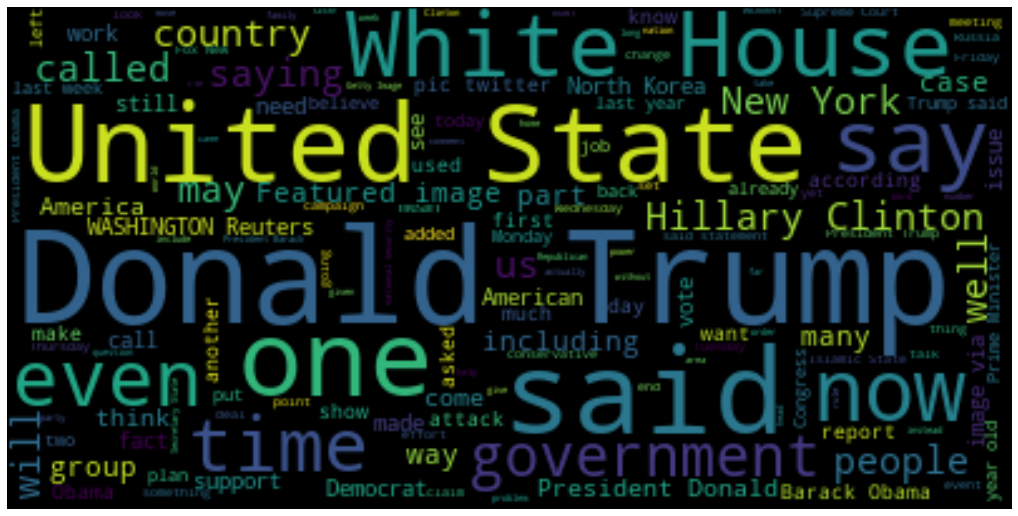

In [42]:
# generate word cloud
wc.generate(' '.join(df_train['text']))

# plot wordcloud
plt.figure(figsize=(18, 12))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

We can see that `Donald Trump` and `United State` show up quite often.\
Let's separate between the fake and real news and see how they differ

In [ ]:
# generate word cloud
wc.generate(' '.join(df_train[df_train['target'] == 0]['text']))

# plot wordcloud
plt.figure(figsize=(18, 12))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

The word `said` definitely popped out in this picture

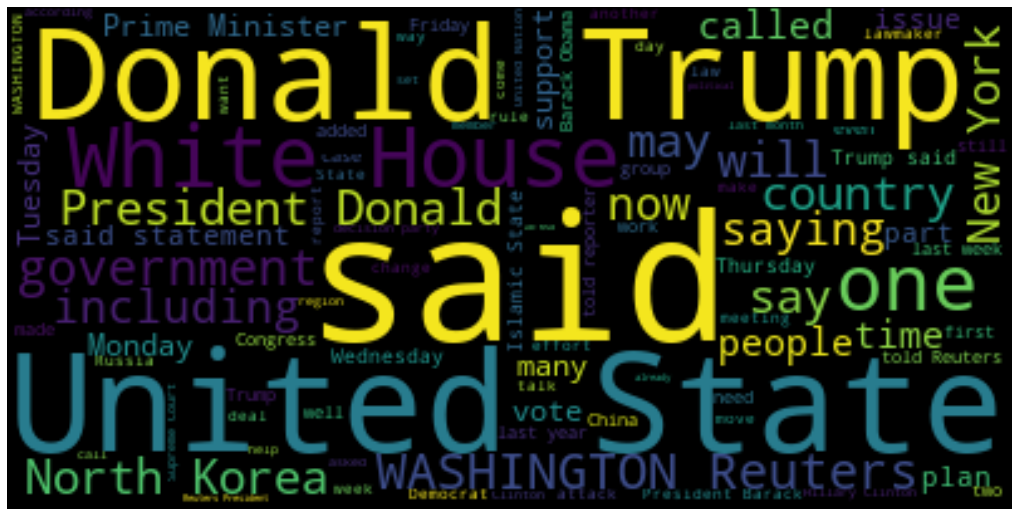

In [44]:
# generate word cloud
wc.generate(' '.join(df_train[df_train['target'] == 1]['text']))

# plot wordcloud
plt.figure(figsize=(18, 12))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

But the same thing can be said with this picture as well. They're both quite similar

# 5. Data Preprocessing

In [28]:
# restore the train set from the backup
df_train = df_train_ori.copy()

In [29]:
# split between features and target
X_train = df_train.drop(['target'], axis=1)
y_train = df_train['target'].copy()

X_valid = df_valid.drop(['target'], axis=1)
y_valid = df_valid['target'].copy()

X_test = df_test.drop(['target'], axis=1)
y_test = df_test['target'].copy()

## Handling Missing Values

We don't have any nan missing values. However, we found out during our EDA that some instances in our dataset contains nothing but links. Therefore, we are going to drop these entries as they do not provide any value in 

In [30]:
# check links only value in train set
check_links_only(X_train)

,feats,tot_missing,tot_missing_pct
0,title,6,0.02
1,text,51,0.18
2,date,6,0.02


In [31]:
# check links only value in validation set
check_links_only(X_valid)

,feats,tot_missing,tot_missing_pct
0,text,11,0.15


In [32]:
# check links only value in test set
check_links_only(X_test)

,feats,tot_missing,tot_missing_pct
0,title,3,0.03
1,text,20,0.22
2,date,3,0.03


It seems like there are some instances of data whose title is not link, but the text contains only link. Let's check these data

In [33]:
# display the first five rows of data which have normal titles, but link in text
X_train[
    ~(X_train['title'].str.contains(r'^http\S+$', regex=True)) &
    (X_train['text'].str.contains(r'^http\S+$', regex=True))
].head()

,title,text,subject,date
19262,WOW! CHUCK TODD Goes After Nasty Chuck Schumer...,https://www.youtube.com/watch?v=EOr9fwoc_mo,left-news,"Jan 22, 2017"
11736,RADICAL DIRECTOR OF SIERRA CLUB: Abortion is t...,https://www.youtube.com/watch?time_continue=13...,politics,"Feb 4, 2017"
11882,HEATED! TUCKER CARLSON Totally Shuts Down Radi...,https://www.youtube.com/watch?v=RRPSCqkAJgk,politics,"Jan 17, 2017"
19047,NEWT GINGRICH Punches Back At Democrats With M...,https://www.youtube.com/watch?v=PjeOoJyPNCk,left-news,"Mar 3, 2017"
12315,WOW! Leftist Bully ROSIE O’DONNELL PUSHES Horr...,https://twitter.com/Rosie/status/8009393386158...,politics,"Nov 23, 2016"


It seems like the links in the text point out to different websites.\
I'm not going to drop these kinds of instances, since the values in the title feature could still be useful as predictors.\
Therefore, I'm only dropping instances of data which title is links

In [34]:
# list of features that we want to impute
impute_cols = ['title', 'date']

In [71]:
# print dataset shape before handling links in title
print('X_train and y_train shape before handling links in title:', X_train.shape, y_train.shape)
print('X_valid and y_valid shape before handling links in title:', X_valid.shape, y_valid.shape)
print('X_test and y_test shape before handling links in title:', X_test.shape, y_test.shape)

print('=' * 80)

# drop instances of data which has a link as its title
X_train, y_train_final = drop_title_links_only(X_train, y_train, impute_cols)
X_valid, y_valid_final = drop_title_links_only(X_valid, y_valid, impute_cols)
X_test, y_test_final = drop_title_links_only(X_test, y_test, impute_cols)

# print dataset shape after handling links in title
print('X_train and y_train_final shape after handling links in title:', X_train.shape, y_train_final.shape)
print('X_valid and y_valid_final shape after handling links in title:', X_valid.shape, y_valid_final.shape)
print('X_test and y_test_final shape after handling links in title:', X_test.shape, y_test_final.shape)


X_train and y_train shape before handling links in title: (28594, 4) (28594,)
X_valid and y_valid shape before handling links in title: (7151, 4) (7151,)
X_test and y_test shape before handling links in title: (8935, 4) (8935,)
X_train and y_train_final shape after handling links in title: (28594, 4) (28594,)
X_valid and y_valid_final shape after handling links in title: (7151, 4) (7151,)
X_test and y_test_final shape after handling links in title: (8935, 4) (8935,)


Great! We have no more missing values

## Feature Selection

In [36]:
# display the first five rows of the train set
X_train.head()

,title,text,subject,date
604,This Fantastic Obama Speech Shows Us How A RE...,We just took a massive step closer to nuclear ...,News,"August 9, 2017"
20996,DISTURBING TRUTH ABOUT How The UN Decides Whic...,Every American should know the corrupt UN has ...,left-news,"Feb 16, 2016"
34761,"Tillerson, Lavrov agree to continue North Kore...",WASHINGTON (Reuters) - The United States and R...,worldnews,"December 27, 2017"
28665,Cabinet members lobby Trump to remove Iraq fro...,WASHINGTON (Reuters) - Senior Cabinet members ...,politicsNews,"March 2, 2017"
44461,"In Athens, Macron to urge renewal of EU democracy",PARIS (Reuters) - French President Emmanuel Ma...,worldnews,"September 5, 2017"


- We mentioned that we are going to combine the `title` and `text` features since they both make up the major part of a news
- We're going to drop `subject`, since we found out during our EDA that fake and real news have totally different subjects
- We're also going to drop `date`, since date do not have any influence in an NLP model. We're not attempting to find a pattern on when a fake news might be released. We're attempting to spot a fake news based on its content

In [37]:
# combine title and text features
X_train_combined = combine_text(X_train, 'news', 'title', 'text')
X_valid_combined = combine_text(X_valid, 'news', 'title', 'text')
X_test_combined = combine_text(X_test, 'news', 'title', 'text')

# drop `subject` and `date`
X_train_combined = X_train_combined.drop(['subject', 'date'], axis=1)
X_valid_combined = X_valid_combined.drop(['subject', 'date'], axis=1)
X_test_combined = X_test_combined.drop(['subject', 'date'], axis=1)

# print datasets shape
print(f'X_train_combined shape: {X_train_combined.shape}')
print(f'X_valid_combined shape: {X_valid_combined.shape}')
print(f'X_test_combined shape: {X_test_combined.shape}')

X_train_combined shape: (28594, 1)
X_valid_combined shape: (7151, 1)
X_test_combined shape: (8935, 1)


## Text Preprocessing

In [38]:
# display the first five rows of the train set
X_train_combined.head()

,news
604,This Fantastic Obama Speech Shows Us How A RE...
20996,DISTURBING TRUTH ABOUT How The UN Decides Whic...
34761,"Tillerson, Lavrov agree to continue North Kore..."
28665,Cabinet members lobby Trump to remove Iraq fro...
44461,"In Athens, Macron to urge renewal of EU democr..."


In [39]:
# declare stopwords set
stops = set(stopwords.words('english'))

# declare stemmer object
stemmer = PorterStemmer()

# declare spacy object as lemmatizer
lemmatizer = spacy.load('en_core_web_sm')

In [40]:
%%time

# cleaned text 
X_train_combined['news_cleaned'] = X_train_combined['news'].apply(lambda x: clean_text(x))
X_valid_combined['news_cleaned'] = X_valid_combined['news'].apply(lambda x: clean_text(x))
X_test_combined['news_cleaned'] = X_test_combined['news'].apply(lambda x: clean_text(x))

# strip text of stopwords
X_train_combined['news_cleaned'] = X_train_combined['news_cleaned'].apply(lambda x: strip_stopwords(x))
X_valid_combined['news_cleaned'] = X_valid_combined['news_cleaned'].apply(lambda x: strip_stopwords(x))
X_test_combined['news_cleaned'] = X_test_combined['news_cleaned'].apply(lambda x: strip_stopwords(x))

# stem text
X_train_combined['news_stemmed'] = X_train_combined['news_cleaned'].apply(lambda x: stem_text(x))
X_valid_combined['news_stemmed'] = X_valid_combined['news_cleaned'].apply(lambda x: stem_text(x))
X_test_combined['news_stemmed'] = X_test_combined['news_cleaned'].apply(lambda x: stem_text(x))

# lemmatize stemmed text
X_train_combined['news_lemmatized'] = X_train_combined['news_stemmed'].apply(lambda x: lemmatize_text(x))
X_valid_combined['news_lemmatized'] = X_valid_combined['news_stemmed'].apply(lambda x: lemmatize_text(x))
X_test_combined['news_lemmatized'] = X_test_combined['news_stemmed'].apply(lambda x: lemmatize_text(x))

# 6. Model Definition

- Target: Predicting whether the client would stop their subscription and leave the company


- Predictors: The features I'm going to use are


- Models: I'm going to use 

## Create dataset

In [114]:
# choosing which kinds of text to process
col = 'news_lemmatized'

X_train_final = X_train_combined[col]
X_valid_final = X_valid_combined[col]
X_test_final = X_test_combined[col]

In [115]:
# create batch size variable
batch_size = 64

# create tf dataset instance 
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_final, y_train_final)).batch(batch_size)
valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid_final, y_valid_final)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_final, y_test_final)).batch(batch_size)

## Tokenization

In [116]:
# declare vectorizer object
Vectorize = CountVectorizer()

# fit vectorize object to the train set
Vectorize.fit(X_train_final)

CountVectorizer()

In [117]:
# display the top ten vocabs
print(f'There are {len(Vectorize.vocabulary_.keys())} vocabulary')
print('These are the top ten:')
print(list(Vectorize.vocabulary_.keys())[:10])

There are 64361 vocabulary
These are the top ten:
['fantast', 'obama', 'speech', 'show', 'we', 'real', 'presid', 'would', 'act', 'right']


In [118]:
# decide on the percentage of vocab to include
pct_vocab = 0.75

# calculate on the number of features to include
max_features = int(np.floor(0.75 * len(Vectorize.vocabulary_.keys())))

# calculate on number of output sequence length based on mean sentence length
max_seq_len = int(np.floor(np.mean([len(i.split(' ')) for i in X_train_final])))

# print max number of vocabs and output sequence length
print(f'Max number of vocabs: {max_features}')
print(f'Output sequence length: {max_seq_len}')

Max number of vocabs: 48270
Output sequence length: 241


In [119]:
# create keras vectorization layer
vectorize_layer = TextVectorization(
    max_tokens=max_features,
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    ngrams=None,
    output_mode='int',
    output_sequence_length=max_seq_len,
)

# adapt vectorization layer to the train set
vectorize_layer.adapt(X_train_final)

In [169]:
# create keras embbeding layer
embedding_layer = Embedding(
    input_dim=max_features,
    output_dim=32,
    input_length=max_seq_len,
)

## DNN Model

Running this model as minimal as possible. Using 1 hidden layer with 8 neurons

In [170]:
# declare keras model using Sequential API
model_dnn = Sequential([
    InputLayer(input_shape=(1,), dtype=tf.string),
    vectorize_layer,
    embedding_layer,
    GlobalAveragePooling1D(),
    Dense(units=8, activation='relu'),
    Dropout(rate=0.2),
    Dense(units=1, activation='sigmoid'),
])

# compile model
model_dnn.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(lr=0.01),
    metrics=['accuracy']
)

# display model summary for sequential model
model_dnn.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_4 (TextV  (None, 241)              0         
 ectorization)                                                   
                                                                 
 embedding_3 (Embedding)     (None, 241, 32)           1544640   
                                                                 
 global_average_pooling1d_8   (None, 32)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_24 (Dense)            (None, 8)                 264       
                                                                 
 dropout_5 (Dropout)         (None, 8)                 0         
                                                                 
 dense_25 (Dense)            (None, 1)               

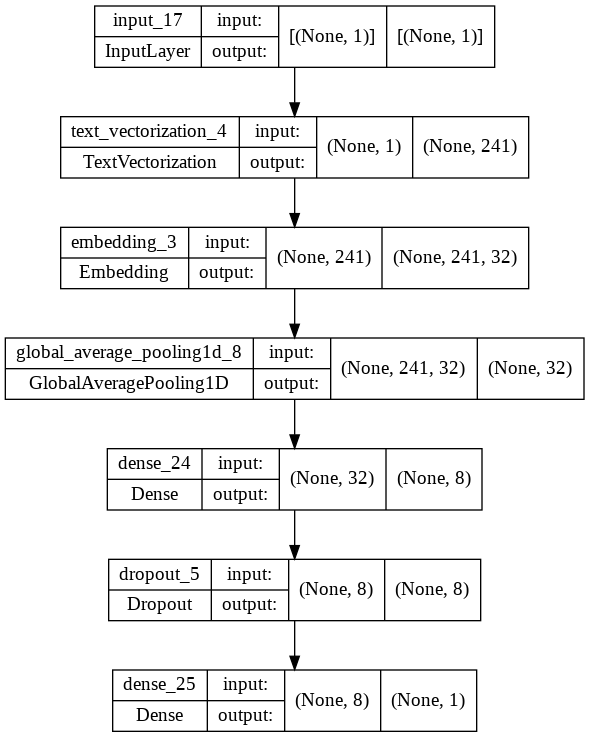

In [171]:
# plot model architecture
keras.utils.plot_model(model_dnn, show_shapes=True)

## LSTM Model

Attempting to improve the sequential model using initializer, regularizer, and also dropout

In [172]:
# declare keras model using Sequential API
model_lstm = Sequential([
    InputLayer(input_shape=(1,), dtype=tf.string),
    vectorize_layer,
    embedding_layer,
    LSTM(8),
    Dropout(rate=0.2),
    Dense(units=1, activation='sigmoid'),
])

# compile model
model_lstm.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(lr=0.01),
    metrics=['accuracy']
)

# display model summary for sequential model
model_lstm.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_4 (TextV  (None, 241)              0         
 ectorization)                                                   
                                                                 
 embedding_3 (Embedding)     (None, 241, 32)           1544640   
                                                                 
 lstm_7 (LSTM)               (None, 8)                 1312      
                                                                 
 dropout_6 (Dropout)         (None, 8)                 0         
                                                                 
 dense_26 (Dense)            (None, 1)                 9         
                                                                 
Total params: 1,545,961
Trainable params: 1,545,961
Non-trainable params: 0
___________________________________________

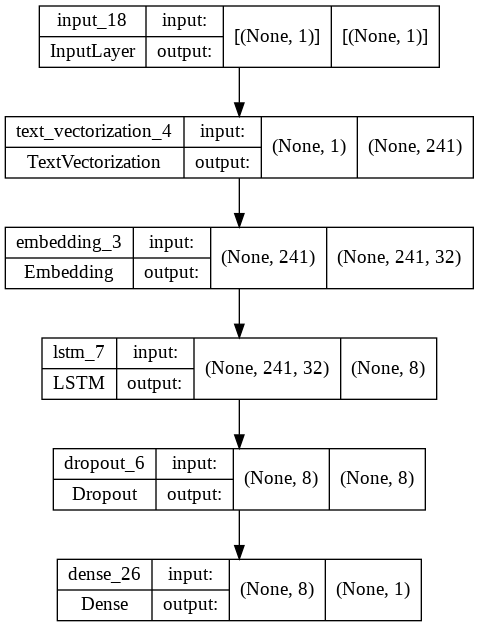

In [173]:
# plot model architecture
keras.utils.plot_model(model_lstm, show_shapes=True)

## GRU Model

Attempting to improve the sequential model using initializer, regularizer, and also dropout

In [174]:
# declare keras model using Sequential API
model_gru = Sequential([
    InputLayer(input_shape=(1,), dtype=tf.string),
    vectorize_layer,
    embedding_layer,
    GRU(8),
    Dropout(rate=0.2),
    Dense(units=1, activation='sigmoid'),
])

# compile model
model_gru.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(lr=0.00),
    metrics=['accuracy']
)

# display model summary for sequential model
model_gru.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_4 (TextV  (None, 241)              0         
 ectorization)                                                   
                                                                 
 embedding_3 (Embedding)     (None, 241, 32)           1544640   
                                                                 
 gru_1 (GRU)                 (None, 8)                 1008      
                                                                 
 dropout_7 (Dropout)         (None, 8)                 0         
                                                                 
 dense_27 (Dense)            (None, 1)                 9         
                                                                 
Total params: 1,545,657
Trainable params: 1,545,657
Non-trainable params: 0
___________________________________________

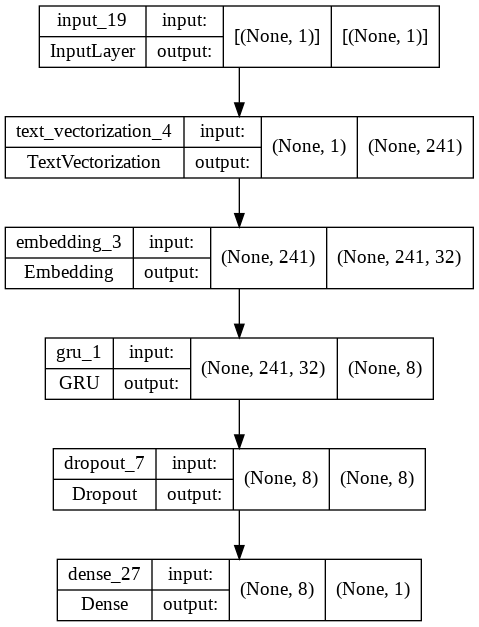

In [175]:
# plot model architecture
keras.utils.plot_model(model_gru, show_shapes=True)

## Additional objects

In [176]:
# define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True ),
    ModelCheckpoint(filepath='models/model_best.tf', monitor='val_loss', save_best_only=True )
]

# 7. Model Training

In [177]:
# create dictionary of models
models = {
    'dnn': model_dnn,
    'lstm': model_lstm,
    'gru': model_gru,
}

In [178]:
%%time

# create dictionary to store metrics
metrics = {}

# loop through models and train
for name, model in models.items():
    # train model
    history = model.fit(
        train_dataset,
        epochs=30,
        validation_data=valid_dataset,
        callbacks=callbacks,
        verbose=0
    )

    # store metrics
    metrics[name] = pd.DataFrame(history.history)

INFO:tensorflow:Assets written to: models/model_best.tf/assets


INFO:tensorflow:Assets written to: models/model_best.tf/assets


CPU times: user 5min 11s, sys: 16.2 s, total: 5min 27s
Wall time: 5min 15s


# 8. Model Evaluation

In [179]:
# create dictionary to store evaluation metrics
eval_metrics = {
    'dnn': {},
    'lstm': {},
    'gru': {},
}

# loop through models and evaluate them
for name, model in models.items():
    # evaluate model
    eval_metrics[name]['loss'], eval_metrics[name]['accuracy'] = model.evaluate(
        test_dataset,
        verbose=0
    )

# create dataframe from evaluation metrics
eval_metrics_df = pd.DataFrame(eval_metrics).T

# display evaluation metrics
eval_metrics_df

,loss,accuracy
dnn,1.88,0.65
lstm,0.06,0.99
gru,0.84,0.48


We can see that the loss actually increased after being tuned. The accuracy also slightly decreased

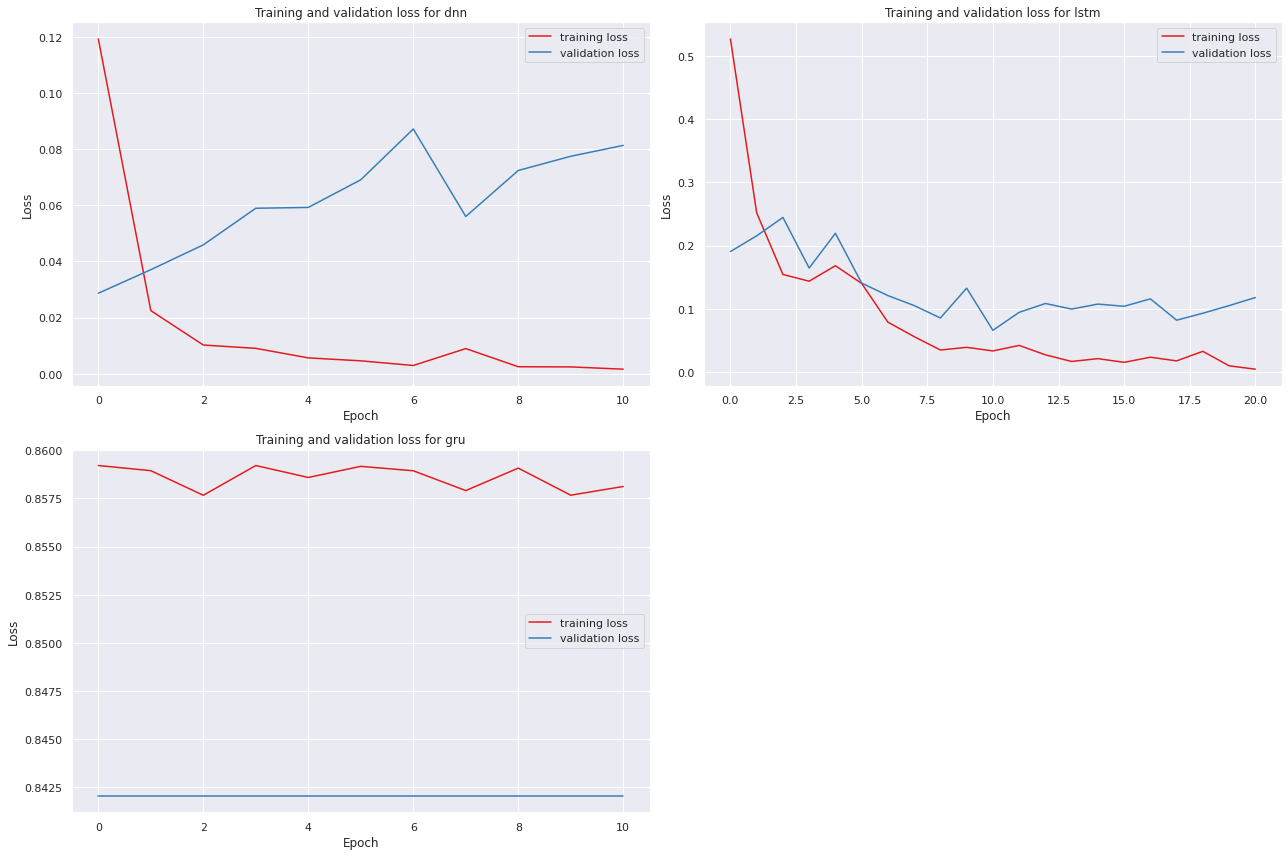

In [180]:
plt.figure(figsize=(18, 12))

# plot the loss curves
for i, (name, metric) in enumerate(metrics.items()):
    plt.subplot(2, 2, i + 1)
    plot_loss(metric)
    plt.title(f'Training and validation loss for {name}')

plt.tight_layout()
plt.show()

- Even though the sequential and functional model uses the same hyperparameter, the results are actually slightly different
- We can see from the graph, that the functional model is a bit overfitted as we started to see the gap widening the higher the epoch.
- The sequential model also had a widening of the gap, albeit more subtly.
- The tuned models, be it sequential or functional are now a much more better fit, we could even call it a good fit. We also have the validation loss to be slightly lower than the training loss.
- We do have to note though that the absolute value of the loss increased after tuning. So we still have to see how it performs when we use it to predict the test set

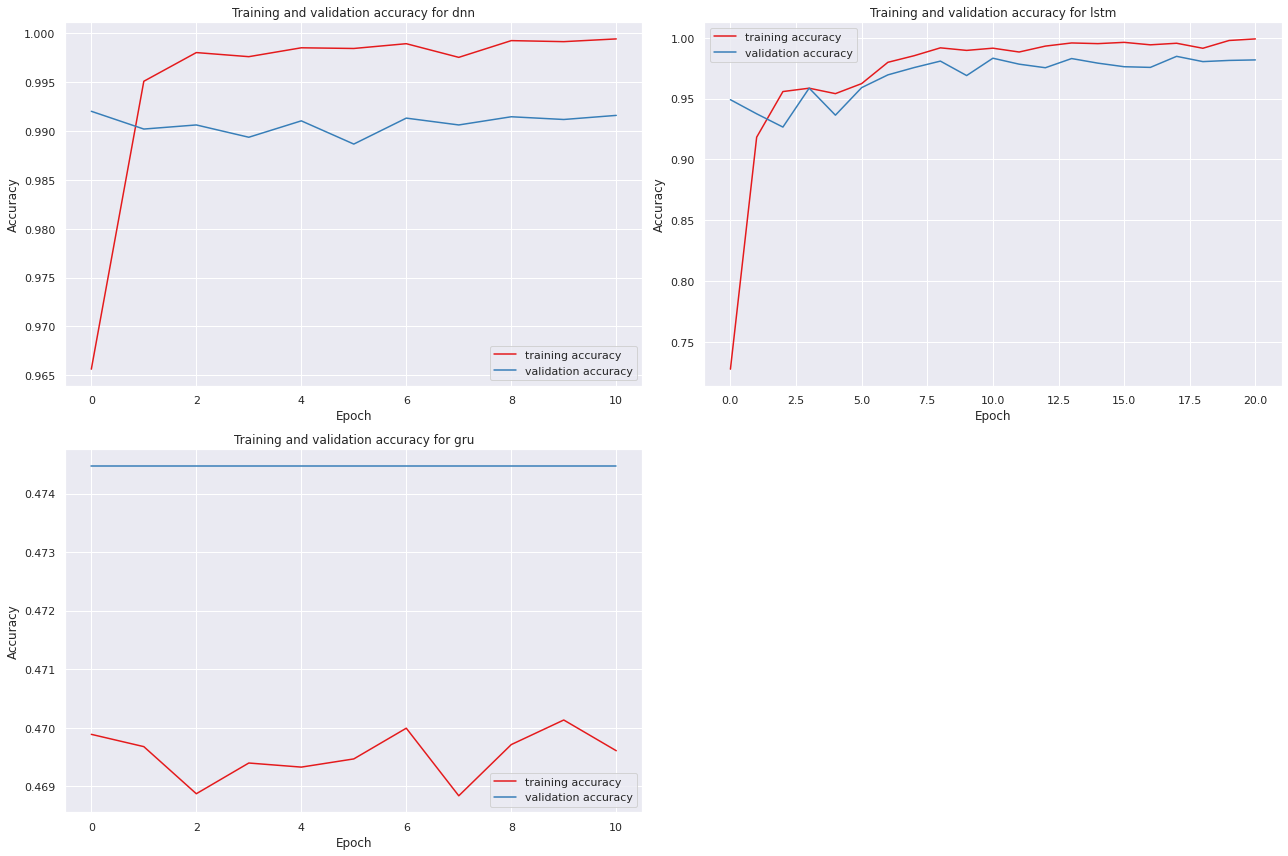

In [181]:
plt.figure(figsize=(18, 12))

# plot the accuracy curves
for i, (name, metric) in enumerate(metrics.items()):
    plt.subplot(2, 2, i + 1)
    plot_acc(metric)
    plt.title(f'Training and validation accuracy for {name}')

plt.tight_layout()
plt.show()

- We can see that the accuracy also somewhat decreased after tuning
- The validation accuracy for the tuned models are quite high from the start but didn't increase much as it stabilized later on

## Prepare Evaluation

In [152]:
# set threshold for prediction
threshold = 0.5

# create dictionary to store predictions:
predictions = {
    'sequential': {},
    'sequential_tuned': {},
    'functional': {},
    'functional_tuned': {},    
}

# loop through models and make predictions
for name, model in models.items():
    # make predictions for training set
    pred_train = model.predict(X_train_final).reshape(-1)
    pred_train = np.where(pred_train > threshold, 1, 0)

    # make predictions for test set
    pred_test = model.predict(X_test_final).reshape(-1)
    pred_test = np.where(pred_test > threshold, 1, 0)

    # store predictions in dictionary
    predictions[name]['train'] = pred_train
    predictions[name]['test'] = pred_test

KeyError: ignored

In [ ]:
# prepare target names for classification report
target_names = ["Not Churn", "Churn"]

## Sequential API Evaluation

In [ ]:
# print classification report for sequential API
for name, preds in predictions.items():
    if 'sequential' not in name:
        continue
    for dataset, pred in preds.items():
        if dataset == 'train':
            print(f'{name} classification report for training set:')
            print(classification_report(y_train_final, pred, target_names=target_names))
        if dataset == 'test':
            print(f'{name} classification report for testing set:')
            print(classification_report(y_test_final, pred, target_names=target_names))

sequential classification report for training set:
              precision    recall  f1-score   support

   Not Churn       0.81      0.76      0.79      3311
       Churn       0.78      0.83      0.80      3311

    accuracy                           0.79      6622
   macro avg       0.79      0.79      0.79      6622
weighted avg       0.79      0.79      0.79      6622

sequential classification report for testing set:
              precision    recall  f1-score   support

   Not Churn       0.90      0.75      0.82      1035
       Churn       0.52      0.76      0.62       374

    accuracy                           0.75      1409
   macro avg       0.71      0.75      0.72      1409
weighted avg       0.80      0.75      0.76      1409

sequential_tuned classification report for training set:
              precision    recall  f1-score   support

   Not Churn       0.82      0.73      0.77      3311
       Churn       0.76      0.84      0.80      3311

    accuracy            

- We can now see clearly that both model are not actually a very good fit. I don't think it can be called overfit either though. So I'd call it a decent fit, but it sure could be improved, as there is a `0.04` gap between training accuracy and testing accuracy
- We can also see that tuning the model successfully increased the recall score. This is important to us as we want to minimize **False Negatives**, since we need to detect potential of churning as much as possible.
- The tuned recall score is `0.79` which is quite decent
- Therefore, our model could be run on inference, but we should also strive to improve this model further

## Functional API Evaluation

In [ ]:
# print classification report for functional API
for name, preds in predictions.items():
    if 'functional' not in name:
        continue
    for dataset, pred in preds.items():
        if dataset == 'train':
            print(f'{name} classification report for training set:')
            print(classification_report(y_train_final, pred, target_names=target_names))
        if dataset == 'test':
            print(f'{name} classification report for testing set:')
            print(classification_report(y_test_final, pred, target_names=target_names))

functional classification report for training set:
              precision    recall  f1-score   support

   Not Churn       0.82      0.75      0.78      3311
       Churn       0.77      0.84      0.80      3311

    accuracy                           0.79      6622
   macro avg       0.80      0.79      0.79      6622
weighted avg       0.80      0.79      0.79      6622

functional classification report for testing set:
              precision    recall  f1-score   support

   Not Churn       0.90      0.73      0.81      1035
       Churn       0.51      0.77      0.61       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.76      1409

functional_tuned classification report for training set:
              precision    recall  f1-score   support

   Not Churn       0.85      0.70      0.77      3311
       Churn       0.75      0.87      0.81      3311

    accuracy            

- The fit situation is quite similar with the sequential models. However, the fit in the tuned model actually became even wider, with a `0.07` gap between training accuracy and testing accuracy
- Tuning the model increased the recall score substantially to `0.82`, which is good
- So this model is also good, but I'm quite concerned with the wider gap indicating overfit.

## Analysis
- Tuning successfully increased the recall score
- The fit on the functional_tuned model actually became wider, indicating that the fit became a tad worse
- Therefore, considering the fit and also the recall score, I'm choosing the **sequential_tuned** model as the best model to be saved and run

## Save The Final Model

In [ ]:
# prepare directory for saving model
model_dir = 'models'
scaler_name = 'scaler.pkl'
encoder_name = 'encoder.pkl'
model_name = 'keras_model.h5'

# create directory if it does not exist
Path(model_dir).mkdir(parents=True, exist_ok=True)

scaler_path = Path(model_dir, scaler_name)
encoder_path = Path(model_dir, encoder_name)
model_path = Path(model_dir, model_name)

# save model
joblib.dump(scale, scaler_path)
joblib.dump(encode, encoder_path)
model_seq_tuned.save(model_path)

# 9. Model Inference

## Load The Model

In [ ]:
# model location
model_dir = 'models'
scaler_name = 'scaler.pkl'
encoder_name = 'encoder.pkl'
model_name = 'keras_model.h5'

# create path object
scaler_path = Path(model_dir, scaler_name)
encoder_path = Path(model_dir, encoder_name)
model_path = Path(model_dir, model_name)

# load model
scaler = joblib.load(scaler_path)
encoder = joblib.load(encoder_path)
model = keras.models.load_model(model_path)

## Prepare Data For Inferencing

In [ ]:
# prepare data for inferencing
new_data = {
    'gender': 'Female',
    'SeniorCitizen': 0,
    'Partner': 'Yes',
    'Dependents': 'No',
    'tenure': 12,
    'PhoneService': 'No',
    'MultipleLines': 'No phone service',
    'InternetService': 'Fiber optic',
    'OnlineSecurity': 'No',
    'OnlineBackup': 'No',
    'DeviceProtection': 'No',
    'TechSupport': 'No',
    'StreamingTV': 'No',
    'StreamingMovies': 'No',
    'Contract': 'Month-to-month',
    'PaperlessBilling': 'Yes',
    'PaymentMethod': 'Electronic check',
    'MonthlyCharges': 50,
    'TotalCharges': 600,
}

new_data_2 = {
    'gender': 'Male',
    'SeniorCitizen': 0,
    'Partner': 'No',
    'Dependents': 'No',
    'tenure': 41,
    'PhoneService': 'Yes',
    'MultipleLines': 'Yes',
    'InternetService': 'No',
    'OnlineSecurity': 'No internet service',
    'OnlineBackup': 'No internet service',
    'DeviceProtection': 'No internet service',
    'TechSupport': 'No internet service',
    'StreamingTV': 'No internet service',
    'StreamingMovies': 'No internet service',
    'Contract': 'Month-to-month',
    'PaperlessBilling': 'Yes',
    'PaymentMethod': 'Bank transfer (automatic)',
    'MonthlyCharges': 25.25,
    'TotalCharges': 996.45,
}


# create a list for each value in the data dictionary
for key, value in new_data.items():
    new_data[key] = [value]
    
# append new values to the data dictionary
for key, value in new_data.items():
    value.append(new_data_2[key])

# create dataframe for inferencing
new_data = pd.DataFrame(new_data)

In [ ]:
# display dataframe for inferencing
new_data

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,Female,0,Yes,No,12,No,No phone service,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,50.00,600.00
1,Male,0,No,No,41,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Bank transfer (automatic),25.25,996.45


## Inferencing

In [ ]:
# impute missing values
new_data_prepared = impute_total_charges(new_data)

# impute no phone service and no internet service with no
new_data_prepared = impute_no_phone_internet(new_data_prepared)

# print shape of prepared data
print(new_data_prepared.shape)

(2, 19)


In [ ]:
%%time

# set threshold for prediction
threshold = 0.5

# scale inference set
new_data_scaled = scaler.transform(new_data_prepared)

# encode inference set
new_data_encoded = encoder.transform(new_data_scaled)

# cast as float32
new_data_final = new_data_encoded.astype(np.float32)

# predict inference set using the final model
y_pred_new = model.predict(new_data_final).reshape(-1)
y_pred_new = np.where(y_pred_new > threshold, 1, 0)

CPU times: user 54.5 ms, sys: 18.3 ms, total: 72.8 ms
Wall time: 69.1 ms


In [ ]:
# create dataframe with predictions
new_data['pred'] = y_pred_new

# display inference set
new_data

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,pred
0,Female,0,Yes,No,12,No,No phone service,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,50.00,600.00,1
1,Male,0,No,No,41,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Bank transfer (automatic),25.25,996.45,0


Model successfully run on inference dataset

# 10. Conclusion

## On EDA
- Most customers do not churn. Only around 30% customers eventually leave the company. This is pretty good, but we should strive to decrease it
- The number of customers who are male are about equal to those who are female, and they have similar likelihood of churning
- There are more Non-Senior citizens than Seniors and the Senior Citizens are more likely to churn
- The number of customers who have a partner and those who don't are about equal. Customers who do not have a partner are more likely to churn
- Most customers do not have any dependents. Customers who do not have dependents are more likely to churn
- The majority of our customers subscribe to a Phone Service.
- All customers who do not subscribe to a Phone Service, subscribes to DSL internet service
- Those who subscribe to a Phone Service, usually have a Fiber optic as well. This might be a packaged deal where a fiber optic users get a free or discounted phone service
- However, customers who use Fiber optic have about double the likelihood of churning compared to customers who use DSL, and about five times to that of  cutomers who only have a phone service
- Most customers do not have multiple phone lines
- The majority of our customers who have multiple phone lines, uses fiber optic internet service
- Most people who use DSL do not subscribe to additional services.  However, we do have to note that the number of customers who subscribe to online security and tech support are also about equal to those who don't
- Contrary to the DSL users, most Fiber optic users do not subscribe to online security and tech support. Is this because Fiber optic is less prone to cyber attacks, so they opted out of those additional services? We need more information on this. We could ask the online security specialist
- Fiber optics customers tend to subscribe to third-party streaming TV and streaming Movies services. This might be because they have faster, more reliable internet connection and they're also more well-off. So they want better entertainment
- Most people are on a month-to-month contract. I don't think this is a good way to retain customers, as shown that they have a higher likelihood of churning
- Customers on a two-year contract retain the customers best, with very low chance of churning.
- Most people use paperless billing and it also has a higher chance of churning compared to those who use paper billing.
- Most people use electronic check as their payment method. This isn't good for customer retention as the customers using this payment method have a higher likelihood of churning
- The data design have some of what I would deemed redundant categories like `No phone service` and `No internet service`, as these can be implied by the situation of their respective parent features of `PhoneService` and `InternetService`. However, separating them like that does make the data easier to be seen and analyze at a glance

## On Modeling
- The data is very imbalance. Hence the need for oversampling
- All the models have quite a decent fit, be it the base or the tuned models. However, the functional model actually became slightly more overfit after tuning, even though it did increase the recall score quite moderately
- Tuning also successfully increased the recall score, which is the metric we deemed important in this research
- Therefore, our model is quite okay with a `79%` recall score.

## Implication
- We cannot please everybody. However, we should still strive to be the best solution for our customers as a phone and internet service providers
- By learning from data, we can predict whether a client is dissatisfied with our services and more likely to stop their subscriptions
- This way, we can identify our customers and contact them to find out their needs and concerns as to why they might churn. Then, we can find out what to do and how to improve our services, so we may prevent them from churning.
- However, we want to minimize the event where we misclassify a customer as unlikely to churn, and have a false sense of security, while in all actuality, we should contact them right away and attempt to find out what's wrong, then retain them. This event, in statistical term, is called *False Negative*. This is the event we want to minimize
- Our model is quite decent at predicting this, having only a `79%` rate, so it may be run, but we still need to aim to improve it gradually
- Contact those customers who are more likely to churn and offer them to:
  - Switch to a two-year contract
  - Switch to automatic bank transfer or credit card payment method
  - If they still want to stop their subscriptions, offer them some kind of promotions or discounts while pushing them to use the two options mentioned above. The promotions and discounts will have to be discussed by the marketing department
  - Offer them to downgrade to a phone only service. This way we can still retain the clients 
  - Ask for feedback on what we can improve from our services

## Future Improvement
- Consider adding more data so the model could learn more
- Consider tweaking other hyperparameters like learning rate, batch normalization, optimizers, and so on
- Consider dropping some features which might not be significant to the target variable, such as `gender`, where each gender have about equal chance of churning
- Consider dropping some features which might be related to each other. Like the additional internet services, such as `StreamingTV` and `StreamingMovies`
- Consider keeping the deemed-redundant categories of `No phone service` and `No internet service`